In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.core.display import display, HTML

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from pathlib import PosixPath
import random
import matplotlib.pyplot as plt
%matplotlib inline 

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
seed = random.randint(0,100)
random.seed(seed)
seed = random.randint(0,1250)
print(f"Current seed : {seed}")

Current seed : 384


In [3]:
root_path = '/content/drive/MyDrive/archive/train'
data_dir = PosixPath(root_path)
image_count = len(list(data_dir.glob("*/*")))
print(f"Image count: {image_count}")

Image count: 340


In [4]:
class_names = os.listdir(root_path)
class_names

['pepsi', 'cocacola']

In [5]:
class_distribution = [len(os.listdir(root_path + '/' + name)) for name in class_names]
class_distribution

[170, 170]

(270, 230, 3)


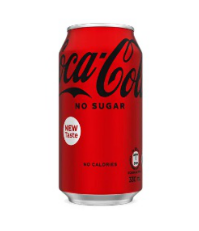

In [6]:
img_path=r'/content/drive/MyDrive/archive/train/cocacola/100.jpg'
img=plt.imread(img_path)
print (img.shape)
plt.axis('off')
plt.imshow(img)
plt.show()

In [7]:
def preprocess (sdir, trsplit, random_seed):
    filepaths=[]
    labels=[]

    classlist=os.listdir(sdir)

    for klass in classlist:

        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)

        for f in flist:

            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)

    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)

    # split df into train_df and test_df 
    dsplit=(1-trsplit)
    strat=df['labels']    
    train_df, valid_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=random_seed, stratify=strat)
    print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df))
    return train_df, valid_df

In [8]:
sdir=r'/content/drive/MyDrive/archive/train'
train_df, valid_df = preprocess(sdir, .8, seed)

train_df length:  272   valid_df length:  68


In [9]:
filepaths=[]
labels=[]

classlist = os.listdir('/content/drive/MyDrive/archive/test')

for klass in classlist:

    classpath=os.path.join(sdir,klass)
    flist=os.listdir(classpath)

    for f in flist:

        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)

Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
test_df=pd.concat([Fseries, Lseries], axis=1)
print('test_df length: ', len(test_df))

test_df length:  340


In [10]:
img_size=(100,100)
channels=3
batch_size=32
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  68   test steps:  5


In [11]:
def scalar(img):    
    return img  # EfficientNet expects pixels in range 0 to 255 so no scaling is required

trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())

Found 272 validated image filenames belonging to 2 classes.
Found 340 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


In [12]:
class_count=len(classes)
print(class_count)

2


In [22]:
best_model = ModelCheckpoint('/content/drive/MyDrive/bestmodel.hdf5', monitor='accuracy', save_best_only=True)
best_val_acc = ModelCheckpoint('/content/drive/MyDrive/best_val_acc.hdf5', monitor='val_accuracy', save_best_only=True)

In [23]:
model = Sequential([

Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, channels)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Flatten(),
Dense(512, activation='relu'),
BatchNormalization(),
Dropout(0.5),
Dense(2, activation='softmax'),
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])

In [24]:
history=model.fit(x=train_gen,  epochs=5, verbose=2,validation_data=valid_gen, callbacks=[
    best_model, best_val_acc],
    shuffle=True,  initial_epoch=0)

Epoch 1/5
9/9 - 12s - loss: 0.6005 - accuracy: 0.7684 - val_loss: 2.9342 - val_accuracy: 0.7500 - 12s/epoch - 1s/step
Epoch 2/5
9/9 - 8s - loss: 0.1660 - accuracy: 0.9375 - val_loss: 0.2019 - val_accuracy: 0.9559 - 8s/epoch - 934ms/step
Epoch 3/5
9/9 - 8s - loss: 0.1372 - accuracy: 0.9596 - val_loss: 0.7882 - val_accuracy: 0.8529 - 8s/epoch - 931ms/step
Epoch 4/5
9/9 - 8s - loss: 0.1003 - accuracy: 0.9706 - val_loss: 0.5809 - val_accuracy: 0.8676 - 8s/epoch - 886ms/step
Epoch 5/5
9/9 - 8s - loss: 0.0488 - accuracy: 0.9816 - val_loss: 0.3212 - val_accuracy: 0.8971 - 8s/epoch - 885ms/step


In [25]:
def visualization(name,h,color):
  t = h.history[name]
  my_max = max(t)
  my_min = min(t)
  print(f'Name : {name} max : {my_max} min : {my_min}')
  plt.plot(t,color=color,linewidth=3.0)
  plt.title(name)
  plt.ylabel(name)
  plt.xlabel('Epoch')
  plt.legend([name],loc='upper left')
  plt.show()

Name : accuracy max : 0.9816176295280457 min : 0.7683823704719543


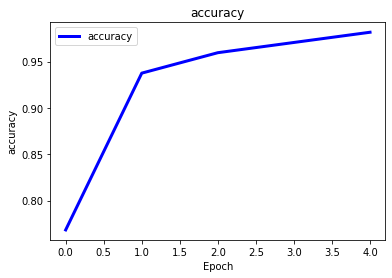

Name : loss max : 0.6005160808563232 min : 0.048830702900886536


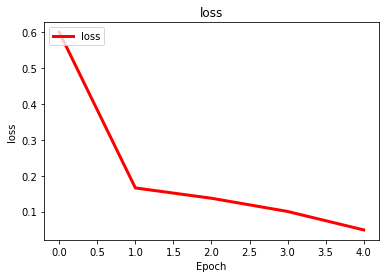

Name : val_accuracy max : 0.9558823704719543 min : 0.75


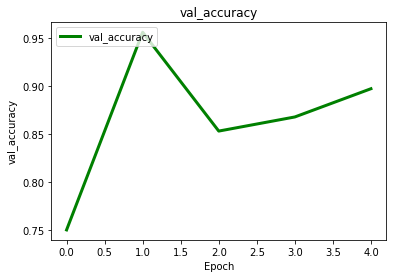

Name : val_loss max : 2.9342265129089355 min : 0.20189857482910156


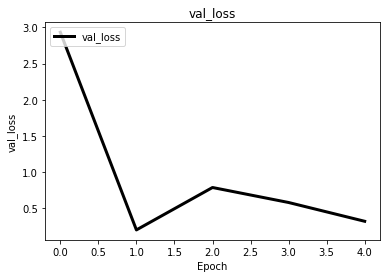

In [26]:
visualization('accuracy',history,'Blue')
visualization('loss',history,'Red')
visualization('val_accuracy',history,'Green')
visualization('val_loss',history,'Black')

In [27]:
model.load_weights('/content/drive/MyDrive/bestmodel.hdf5')
accuracy=model.evaluate (test_gen, steps=test_steps)[1]
print(f'accuracy on test set = {accuracy:6.2f}')

5/5 [==============================] - 3s 469ms/step - loss: 0.1693 - accuracy: 0.9382
accuracy on test set =   0.94


In [28]:
predictions = model.predict_generator(test_gen, steps=test_steps)
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


              precision    recall  f1-score   support

    cocacola       1.00      0.88      0.93       170
       pepsi       0.89      1.00      0.94       170

    accuracy                           0.94       340
   macro avg       0.95      0.94      0.94       340
weighted avg       0.95      0.94      0.94       340

[[149  21]
 [  0 170]]


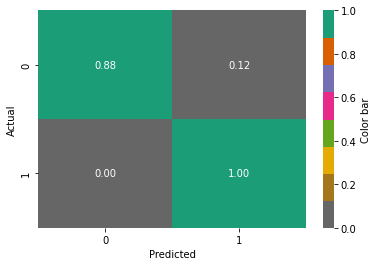

In [30]:
cm_norm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_norm,cmap='Dark2_r',annot=True,
              cbar_kws={'orientation' : 'vertical','label' : 'Color bar'},
              fmt='.2f'
              )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

5/5 [==============================] - 3s 467ms/step - loss: 0.2489 - accuracy: 0.9529
accuracy on test set =   0.95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


              precision    recall  f1-score   support

    cocacola       0.92      0.99      0.95       170
       pepsi       0.99      0.91      0.95       170

    accuracy                           0.95       340
   macro avg       0.96      0.95      0.95       340
weighted avg       0.96      0.95      0.95       340

[[169   1]
 [ 15 155]]


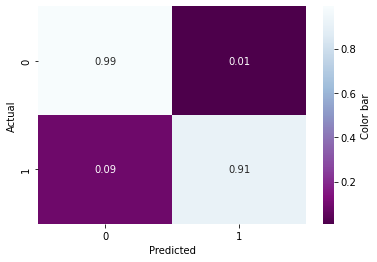

In [32]:
model.load_weights('/content/drive/MyDrive/best_val_acc.hdf5')
accuracy=model.evaluate (test_gen, steps=test_steps)[1]
print(f'accuracy on test set = {accuracy:6.2f}')

predictions = model.predict_generator(test_gen, steps=test_steps)
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

cm_norm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_norm,cmap='BuPu_r',annot=True,
              cbar_kws={'orientation' : 'vertical','label' : 'Color bar'},
              fmt='.2f'
              )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_16 (Bat  (None, 98, 98, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_17 (Bat  (None, 47, 47, 64)      

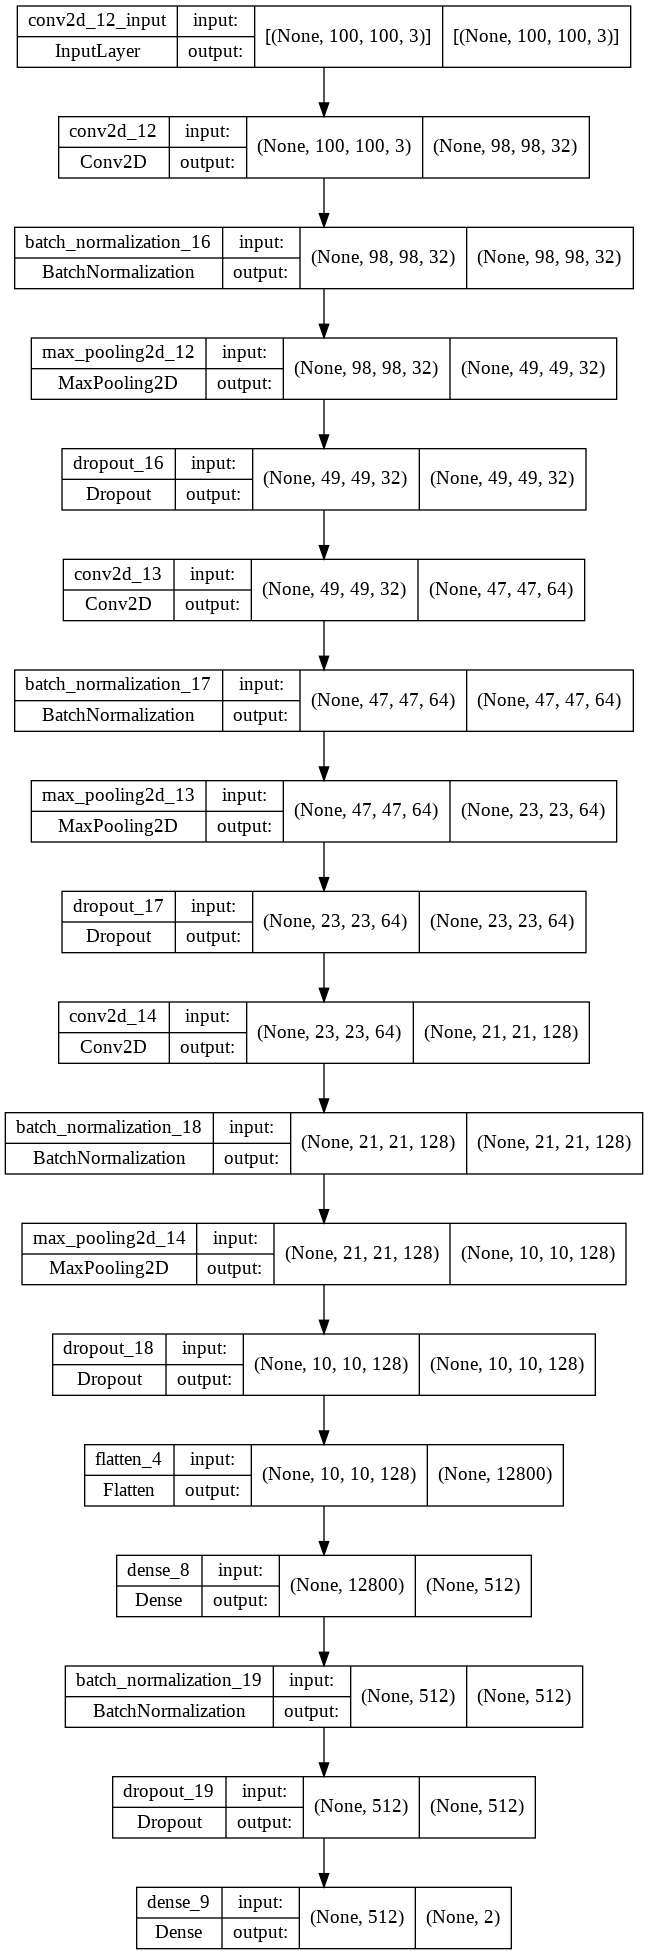

In [34]:
tf.keras.utils.plot_model(model,show_shapes=True)